In [62]:
import os,time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

In [63]:
dir_pth = '/kaggle/input/nlp-getting-started/'

train_df = pd.read_csv(os.path.join(dir_pth,'train.csv'))
print(train_df.shape)
train_df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [64]:
temp_df = train_df[['text','target']].copy(deep=True)
temp_df.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [65]:
temp_df.isna().sum()

text      0
target    0
dtype: int64

In [66]:
!pip install contractions

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [67]:
import re
import contractions
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [68]:
stops = set(stopwords.words('english'))

def remove_puncts(sent):
    return re.sub('[^a-zA-Z ]+','',sent)

def fix_contracts(sent):
    return ' '.join([contractions.fix(token) for token in sent.split()])

def remove_stops(sent):
    return ' '.join([word for word in sent.split() if word.lower() not in stops])

def preprocess_text(sent):
    sent = fix_contracts(sent)
    sent = remove_stops(sent)
    sent = remove_puncts(sent)
    return sent.lower()

In [69]:
temp_df['proc_text'] = temp_df['text'].apply(preprocess_text)

In [70]:
from sklearn.model_selection import train_test_split

In [71]:
X = temp_df['proc_text']
Y = temp_df['target']

train_X,test_X,train_Y,test_Y = train_test_split(X,Y,test_size=0.25,shuffle=True)
print(train_X.shape,train_Y.shape)
print(test_X.shape,test_Y.shape)

(5709,) (5709,)
(1904,) (1904,)


In [72]:
# train_Y

In [73]:
from transformers import AutoTokenizer, AutoModel, TFAutoModel
import numpy as np



def preprocess_trf(text,seq_len):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    if len(new_text) < seq_len:
        new_text += ['[PAD]']*(seq_len-len(new_text))
    return " ".join(new_text)

def get_embedding(text,seq_len):
  text = preprocess_trf(text,seq_len)
  encoded_input = tokenizer(text, return_tensors='pt',max_length=seq_len,truncation=True,padding=True)
  features = model(**encoded_input)
  features = features[0].detach().cpu().numpy() 
#   features_mean = np.mean(features[0], axis=0) 
  return features

MODEL = "cardiffnlp/twitter-roberta-base"
seq_len = 20
embeds_size=768
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModel.from_pretrained(MODEL)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.decoder.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [74]:
data_array = np.zeros((len(train_X),seq_len,embeds_size))
for i,text in enumerate(train_X.tolist()):
    embeds = get_embedding(text,seq_len)
    data_array[i] = embeds[0]
    
print(data_array.shape)

(5709, 20, 768)


In [75]:
data_array_test = np.zeros((len(test_X),seq_len,embeds_size))
for i,text in enumerate(test_X.tolist()):
    embeds = get_embedding(text,seq_len)
    data_array_test[i] = embeds[0]
    
print(data_array_test.shape)

(1904, 20, 768)


In [76]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [87]:
max_seq_len = 20
embed_size = 768
batch_size = 32
n_epochs = 8

input_shape = [max_seq_len,embed_size]
hidden_size = 512
hidden_size2 = 128
hidden_size3 = 32
output_size = 1

In [88]:
lstm_model = keras.Sequential([
    layers.Input(shape=input_shape),
    layers.LSTM(hidden_size,return_sequences=False,activation='relu'),
    layers.Dense(hidden_size2,activation='relu'),
    layers.Dense(hidden_size3,activation='relu'),
    layers.Dense(output_size,activation='sigmoid')
])

In [89]:
lstm_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 512)               2623488   
_________________________________________________________________
dense_12 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_13 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 33        
Total params: 2,693,313
Trainable params: 2,693,313
Non-trainable params: 0
_________________________________________________________________


In [90]:
lstm_model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [91]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.0001,
                              patience=5, min_lr=0.0001)

In [92]:
r = lstm_model.fit(
    data_array,train_Y.values,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data = (data_array_test,test_Y.values),
    callbacks=[reduce_lr]
)

Epoch 1/8
179/179 [==============================] - 30s 157ms/step - loss: 0.4900 - accuracy: 0.7840 - val_loss: 0.4517 - val_accuracy: 0.8083
Epoch 2/8
179/179 [==============================] - 27s 154ms/step - loss: 0.4304 - accuracy: 0.8159 - val_loss: 0.4357 - val_accuracy: 0.8057
Epoch 3/8
179/179 [==============================] - 28s 158ms/step - loss: 0.4048 - accuracy: 0.8318 - val_loss: 0.4242 - val_accuracy: 0.8114
Epoch 4/8
179/179 [==============================] - 28s 157ms/step - loss: 0.4617 - accuracy: 0.8450 - val_loss: 0.4267 - val_accuracy: 0.8162
Epoch 5/8
179/179 [==============================] - 28s 157ms/step - loss: 0.3798 - accuracy: 0.8432 - val_loss: 0.4250 - val_accuracy: 0.8183
Epoch 6/8
179/179 [==============================] - 28s 157ms/step - loss: 0.3363 - accuracy: 0.8585 - val_loss: 0.4310 - val_accuracy: 0.8120
Epoch 7/8
179/179 [==============================] - 28s 156ms/step - loss: 0.3125 - accuracy: 0.8727 - val_loss: 0.4822 - val_accuracy:

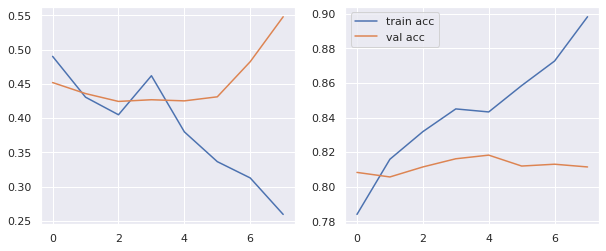

In [93]:
_,axes = plt.subplots(1,2,figsize=(10,4))
axes[0].plot(r.history['loss'],label ='train loss')
axes[0].plot(r.history['val_loss'],label='val loss')

axes[1].plot(r.history['accuracy'],label = 'train acc')
axes[1].plot(r.history['val_accuracy'],label = 'val acc')

plt.legend()

#### Prediction on test data

In [94]:
def predict_encoded(sent):
    sent = preprocess_text(sent)
    encoding = get_embedding(sent,max_seq_len)
    pred = int(lstm_model.predict(encoding)[0][0] > 0.5)
    return pred

In [95]:
test_df = pd.read_csv(os.path.join(dir_pth,'test.csv'))
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [96]:
test_df['target'] = test_df['text'].apply(predict_encoded)
test_df[['id','target']].to_csv('submissions_lstm.csv',index=False)